# Fitting Validation

In this workbook we'll investigate how well the fitting recovers a known signal. Clearly the fitting method performs well, but there are some cases where things could be optimised. Specifically we want to validate how well the peak detection methods work at detecting known peaks, and what set of parameters are optimal. We can then test the fitting code and compare the fitted retrieved parameters to the known parameters. 

We want to try a lot of different conditions that simulate well the types of images we encounter.

## Method

There are two methods we want to employ here. The first method is relatively simple, and involves creating a dummy image with an arbitrary background, an arbitrary noise, where we place an artificial source at the centre. The other were we use real fits to a source and see how well we can retrieve those fit parameters. 

The source will be some multi-component Gaussian with randomly selected parameters, where we restrict the parameter space to be sensible values. We can use the known parameter values as sensible limits on the values. 


### Future Work

Depending on what the parameter space is like, it might be necessary to determine what parameters are best for each image individually. One method we can employ to determine this, is to take an input image for a given source (HII or SNR), calculate the cutout, the background and the rms for the image. Using this information we can create a dummy image from the background and the noise, with an artificial source.

The choice of artificial source is potentially important here, we might want a range of scales for the Gaussian components to accurately test what can be retrieved. In this workbook we can think about what that range should be, and how to determine it for a given source. 

In [1]:
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

import warnings
warnings.filterwarnings("ignore")

# Scipy stuff:
import scipy.optimize as opt

# Astropy stuff:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy import wcs
from astropy.io import fits
from astropy.io.votable import parse_single_table
from astropy.table import Table,Column,vstack
from astropy.io.votable import writeto as writetoVO
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from scipy import ndimage, misc


# Image processing packages:
from skimage.feature import blob_dog
from skimage.feature import blob_log

# Array module.
import numpy as np

# Module for fitting SNRs
from snrfit import NGaussian2D,SNR_Gauss_fit,determine_peaks_bkg
import snrfit

# For downlaoding images.
import gleam_client

### Shit about s

In [2]:
path = '../data/'

filename = 'RA225.71_DEC-41.93_170-231MHz.fits'
#filename = 'SNR228_170-231MHz.fits'
#filename = 'SNR175_170-231MHz.fits'

warnings.filterwarnings("ignore")
with fits.open(path+filename) as hdul:
    #hdul.info()
    header = hdul[0].header
    img_arr = hdul[0].data#[0,0,:,:]


image = np.ones(img_arr.shape)*img_arr

a_psf = header['BMAJ']
b_psf = header['BMIN']
theta_psf = np.radians(header['BPA'])

In [3]:
w = WCS(header).celestial

1338.424058977146 0.8394233345983658 -0.057804234808739474
0.0804293046678172 0.025959393228584326 0.13754716117104096


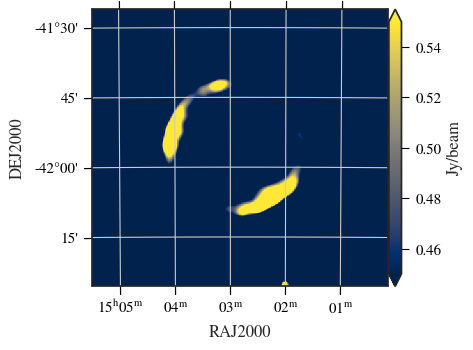

In [8]:
print(np.nansum(img_arr),np.nanmax(img_arr),np.nanmin(img_arr))
print(np.nanmean(img_arr),np.nanmedian(img_arr),np.nanstd(img_arr))

snrfit.astro_plot_2D(img_arr, w, figsize=(7.5,6),scale=0.6, vmax=0.5, vmin=0.5)

In [5]:
X = np.shape(img_arr)[0]
Y = np.shape(img_arr)[1]
print('Image shape (%s,%s)' % (X,Y))

# Defining the pixel grids.
x_pix = np.arange(X)
y_pix = np.arange(Y)
xx_pix, yy_pix = np.meshgrid(x_pix,y_pix)

# This is the pixel scale in degrees.
dx = np.abs(header['CD1_1']) #pixel scale in degrees [deg]

print('dx = %5.3e [deg]' % dx)

Image shape (129,129)
dx = 7.697e-03 [deg]


In [6]:
RA_SN1006 = header['CRVAL1']
DEC_SN1006 = header['CRVAL2']
Major = 0.55*60 #deg

# Getting the corresponding pixel coordinates for the image centre.
x_cent,y_cent = w.wcs_world2pix(RA_SN1006,DEC_SN1006,1)
print('Image pixel center = (%5.3f, %5.3f)' % (x_cent,y_cent))

# The RA and DEC arrays, can use to determine angular mask.
RA_arr, DEC_arr = w.wcs_pix2world(xx_pix + 1, yy_pix + 1, 1)
print('Determined the RA and DEC for the entire pixel grid.')

# Calculating the angular distance from the image centre to each pixel.
theta_dist = np.degrees(snrfit.great_circle_dist(np.radians(DEC_SN1006),
                    np.radians(DEC_arr),np.radians(RA_SN1006),np.radians(RA_arr)))
print('Calculated the angular distance from each pixel to the image centre.')

# Temporary index array. Used for masking the image. Size padded.
theta_ind_arr_ge = theta_dist >= 0.5*Major/60 + 7.5*dx

#img_bkg,rms = snrfit.calc_img_bkg_rms(img_arr,mask_arr=theta_ind_arr_ge,Niter=100)
img_bkg,rms = snrfit.calc_img_bkg_rms(img_arr,mask_arr=theta_ind_arr_ge,sigma_thresh=2.5,Niter=10)

Image pixel center = (64.667, 64.667)
Determined the RA and DEC for the entire pixel grid.
Calculated the angular distance from each pixel to the image centre.


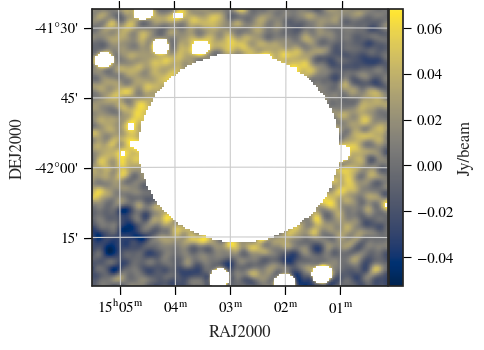

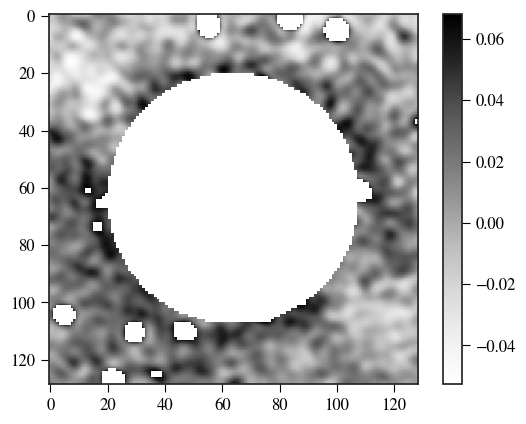

In [7]:
img_nu = np.ones(img_arr.shape)*img_arr# - img_bkg
img_nu[theta_ind_arr_ge == False] = np.nan

snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6)

plt.imshow(img_nu)
plt.colorbar()

### Creating a dummy image and model.

The psf seems to be a little too large, subtracting a small percentage off. There has to be a better fix. Should test some other images.

0.0370158962905407
0.0370158962905407
2.042350888813898 1.9929174409289567
2.4046844059828714 2.346480968995645


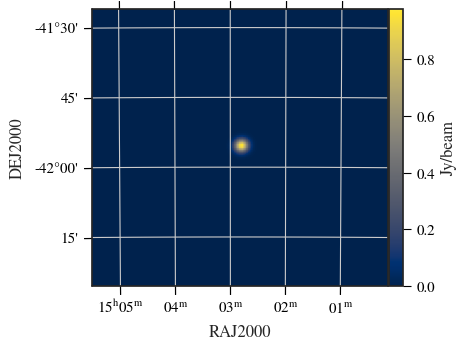

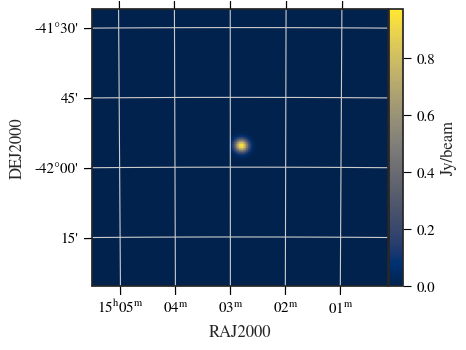

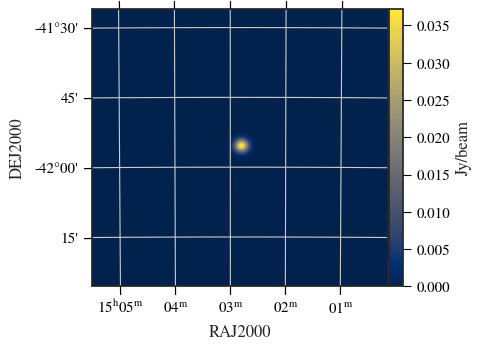

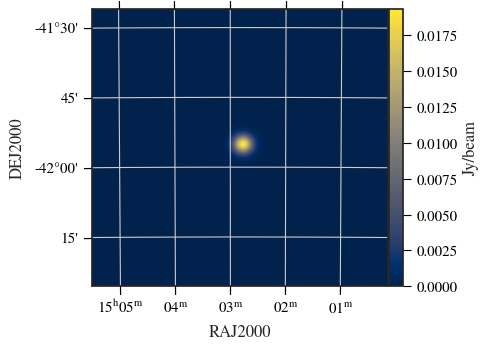

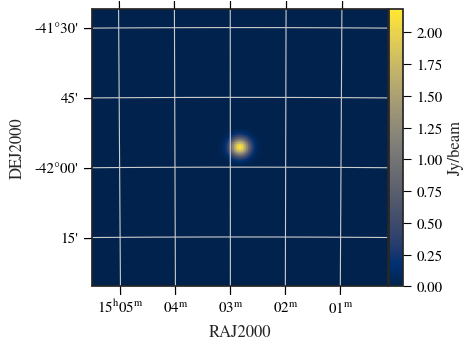

In [8]:

print(a_psf)
# PSF might be too small, adjusting size by the pixel size. 
#a_psf = 2*a_psf + dx
a_psf = a_psf# + dx
b_psf = b_psf# + dx

print(a_psf)


sigx_psf = (1/dx)*a_psf/(2*np.sqrt(2*np.log(2))) 
sigy_psf = (1/dx)*b_psf/(2*np.sqrt(2*np.log(2))) 

print(sigx_psf,sigy_psf)
print(0.5*a_psf/dx,0.5*b_psf/dx)

# Some weird scaling issue. 
#sigx_psf = (1/dx)*a_psf/(2*np.sqrt(2*np.log(2)))
#sigy_psf = (1/dx)*b_psf/(2*np.sqrt(2*np.log(2)))

ratio = 1#(sigy_psf/sigx_psf)**2
pguess = np.array([1,x_cent,y_cent,sigx_psf,sigy_psf,theta_psf])
pguess_2 = np.array([1,x_cent,y_cent,sigx_psf*ratio,sigy_psf*ratio,theta_psf+np.pi/2])
pguess_3 = np.array([1,x_cent,y_cent,sigx_psf*ratio,sigx_psf*ratio,theta_psf+np.pi/2])

zz = NGaussian2D((xx_pix,yy_pix),pguess,fit=False).reshape(X, Y)
zz_2 = NGaussian2D((xx_pix,yy_pix),pguess_2,fit=False).reshape(X, Y)
zz_3 = NGaussian2D((xx_pix,yy_pix),pguess_3,fit=False).reshape(X, Y)

snrfit.astro_plot_2D(zz, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(zz_2, w, figsize=(7.5,6),scale=0.6)

from scipy.signal import convolve2d

zz_circ = convolve2d(zz,zz_2,mode='same',boundary='wrap')

zz_circ = zz_circ/np.sum(zz_circ)
zz_3 = zz_3/np.sum(zz_3)

snrfit.astro_plot_2D(zz_3, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(zz_circ, w, figsize=(7.5,6),scale=0.6)
snrfit.astro_plot_2D(zz_3/zz_circ, w, figsize=(7.5,6),scale=0.6)

The noise needs to be rescaled because the convolution smooths out the noise. There appears to be a relationship between the sum of the original image and the PSF. 

In [9]:
#print(np.nansum(img_nu),np.nanmax(img_nu),np.nanmin(img_nu))
#print(np.nanmean(img_nu),np.nanmedian(img_nu),np.nanstd(img_nu))

rescale = np.sqrt(2*np.pi*(a_psf*b_psf/dx**2) / (8*np.log(2)))

print(2*np.log(2))
print(rescale*2*np.log(2))

sig_maj = (a_psf/dx)/(2*np.sqrt(2*np.log(2)))
sig_min = (b_psf/dx)/(2*np.sqrt(2*np.log(2)))

rescale = 2*np.log(2)*np.sqrt(2*np.pi*sig_maj*sig_min)

print(rescale)

w_a = (a_psf/dx)/np.sqrt(2*np.log(2))
w_b = (b_psf/dx)/np.sqrt(2*np.log(2))

rescale = np.sqrt(2*np.pi*w_a*w_b)/np.sqrt(2)

print(rescale)

#rescale = (np.sqrt(2*np.log(2)))*0.5*np.sqrt(2*np.pi*a_psf*b_psf)/dx

# Normalising the PSF.
zz_nu = zz/np.sum(zz)

#print(rescale)


1.3862943611198906
7.010600575785338
7.010600575785338
7.151790191692788


Rescaling the noise, when we convovlve the PSF will smooth out the noise. 

In [10]:
Nsim = 500
#img_dummy = np.random.normal(loc=img_bkg,scale=rms*rescale,size=(img_arr.shape))
img_dummy = np.random.normal(loc=img_bkg,scale=rms*rescale,size=(img_arr.shape+(Nsim,)))

print(np.nansum(img_dummy),np.nanmax(img_dummy),np.nanmin(img_dummy))
print(np.nanmean(img_dummy),np.nanmedian(img_dummy),np.nanstd(img_dummy))

120753.86070447454 0.8350856215432617 -0.8692703444729635
0.014512813016582483 0.014506145646355918 0.15258941496879055


### Monte Carlo

In [11]:
print(img_arr.shape)

(129, 129)


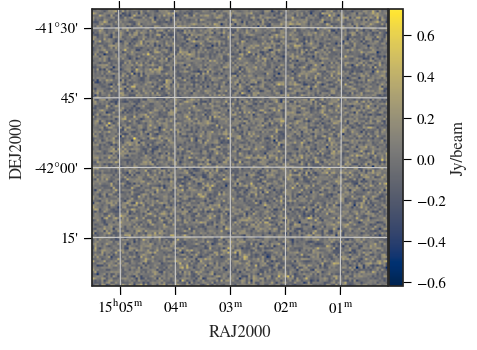

In [12]:

snrfit.astro_plot_2D(img_dummy[:,:,10], w, figsize=(7.5,6),scale=0.6)



In [13]:
from scipy.signal import convolve2d,convolve

#img_dummy_nu = convolve2d(zz_nu,img_dummy,mode='same',boundary='wrap')
img_dummy_nu = [convolve2d(zz_nu,img_dummy[:,:,i],mode='same',boundary='wrap') for i in range(Nsim)]

In [14]:
img_dummy_nu = np.array(img_dummy_nu).T
print(img_dummy_nu.shape)

(129, 129, 500)


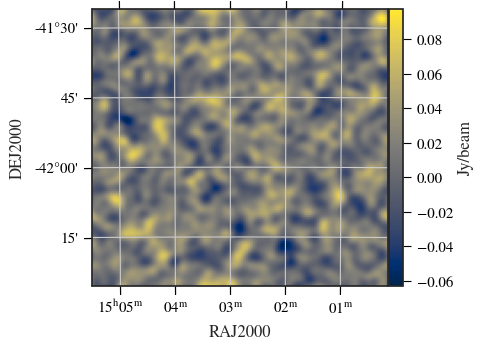

In [15]:

snrfit.astro_plot_2D(img_dummy_nu[:,:,10], w, figsize=(7.5,6),scale=0.6)#,vmax=0.07)


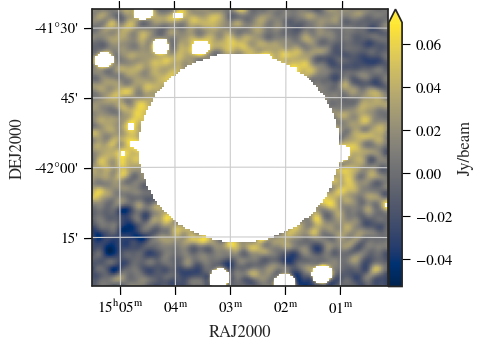

In [16]:
snrfit.astro_plot_2D(img_nu, w, figsize=(7.5,6),scale=0.6,vmax=0.07)

### Making sure we retrieve the statistics.

The stats won't be 100% the same since we are generating a different sample, additionally the variance accross the image might not be constant, and it'self might vary, similar to the background. However the average or expected variane should match what we measure, or be close enough. 

Input image.
0.014618032010344867 0.02135038208780975
Dummy image.
0.014526122078645898 0.021294672830336238


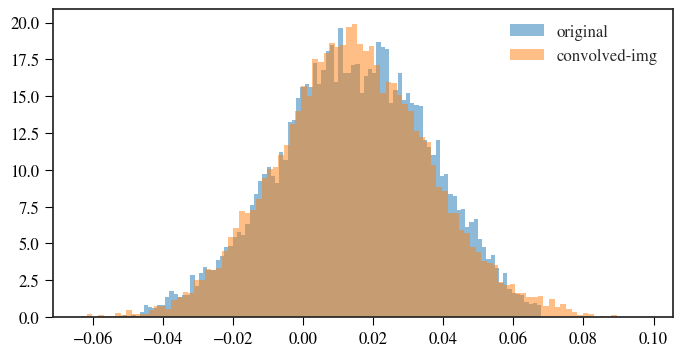

In [17]:
print('Input image.')
print(np.nanmedian(img_nu),np.nanstd(img_nu))
print('Dummy image.')
print(np.nanmedian(img_dummy_nu),np.nanstd(img_dummy_nu))

fig,axs = plt.subplots(1,figsize=(8,4))

axs.hist(img_nu.flatten(),bins = 100,density=True,alpha=0.5,
        label='original')
#plt.show()

axs.hist(img_dummy_nu[:,:,10].flatten(),bins = 100,density=True,alpha=0.5,
        label='convolved-img')
#axs.hist(img_dummy_nu.flatten(),bins = 100,density=True,alpha=0.5,
#        label='convolved-img')


plt.legend()
plt.show()

(500,)
0.02125562563833972 0.0006001470838164197


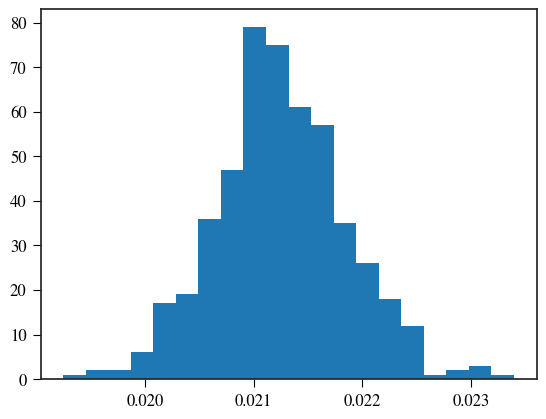

In [18]:
std_vec = np.std(img_dummy_nu,axis=(0,1))

print(std_vec.shape)

print(np.mean(std_vec),np.std(std_vec))

plt.hist(std_vec,bins=20)
plt.show()

### Determining the parameter bounds.

In [19]:
sigx_max = (1/60)*(1/dx)*Major/8
sigy_max = (1/60)*(1/dx)*Major/8

theta_min = 0
theta_max = np.pi/2

amp_min = 0
#amp_max = np.nanmax(image)*0.05
amp_max = np.nanmax(image)/10

theta_pos_min = 0
theta_pos_max = 2*np.pi

r_pos_min = 0
#r_pos_max = ((1/60)*(1/dx)*Major/10) # 1 sigma distance.
r_pos_max = ((1/60)*(1/dx)*Major/(2*3)) # 1 sigma distance.

N_points = 10

r_vec = np.abs(np.random.normal(r_pos_min,r_pos_max,N_points))
theta_pos_vec = np.random.uniform(theta_pos_min,theta_pos_max,N_points)

x_pos = r_vec*np.cos(theta_pos_vec) + x_cent
y_pos = r_vec*np.sin(theta_pos_vec) + y_cent


theta_pa_vec = np.random.uniform(theta_min,theta_max,N_points)

#amp_vec = np.random.uniform(amp_min,amp_max,N_points)
amp_vec = np.abs(np.random.normal(amp_min,amp_max,N_points))

sigx_vec = np.random.uniform(sigx_psf,sigx_max,N_points)
sigy_vec = np.random.uniform(sigy_psf,sigy_max,N_points)


p_list = np.array([[amp_vec[i],x_pos[i],y_pos[i],sigx_vec[i],sigy_vec[i],theta_pa_vec[i]] for i in range(N_points)])

zz_source = NGaussian2D((xx_pix,yy_pix),p_list.ravel(),fit=False).reshape(X, Y)



In [20]:
print(amp_max)


0.08394233345983658


(10, 2)


TypeError: Invalid shape (129, 129, 500) for image data

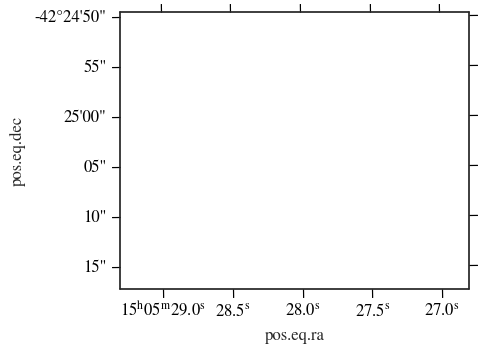

In [21]:

#RA_pos, DEC_pos = w.wcs_pix2world(y_pos + 1, x_pos + 1, 1)
#scatter_points = np.vstack((RA_pos, DEC_pos)).T
scatter_points = np.vstack((y_pos, x_pos)).T


print(scatter_points.shape)

snrfit.astro_plot_2D(img_dummy_nu, w,scatter_points=scatter_points, figsize=(7.5,6),scale=0.6)#,vmax=0.07)
snrfit.astro_plot_2D(img_dummy_nu+zz_source, w, figsize=(7.5,6),scale=0.6)#,vmax=0.07)
snrfit.astro_plot_2D(zz_source, w, figsize=(7.5,6),scale=0.6)#,vmax=0.07)


In [ ]:
#snrfit.astro_plot_2D(image, w,scatter_points=scatter_points, figsize=(7.5,6),scale=0.6)#,vmax=0.07)
